# **Comparison between Glasma and Langevin dynamics for charm and beauty quarks**

### Default simulation parameters for Glasma and Wong solvers
Chosen for a Glasma formed in $\mathrm{Pb}$-$\mathrm{Pb}$ collisions at $5.02\,\mathrm{TeV}$. 

In [4]:
import numpy as np

# hbar * c [GeV * fm]
hbarc = 0.197326 

# Simulation box 
L = 10      
N = 512    
tau_sim = 0.5     
DTS = 8     

# Glasma
su_group = 'su3'
A = 207     
sqrts = 5020       
ns = 50     
factor = 0.8        
Qs = np.sqrt(0.13 * A**(1/3) * sqrts**0.25)         
g = np.pi * np.sqrt(1 / np.log(Qs / 0.2))          		
mu = Qs / (g**2 * factor)           	
ir = 0.1 * g**2 * mu         
uv = 10.0            

# Wong
quark = 'charm'     
mass = 1.275     
tau_form = 0.06   
pT = 0.5    
ntp = 10**5  
nevents = 1    
representation = 'fundamental'      
boundary = 'periodic'
initialization = 'toy'       

# Store relevant parameters in a dictionary
p = {
    'QUARK': quark,
    'MASS': mass,           
    'TFORM': tau_form,       
    'PT': pT,       
    'initialization' : initialization,   
    'NTP' : ntp,
    }

### Set environment variables

In [2]:
import os
os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["PRECISION"] = "double"
os.environ["GAUGE_GROUP"] = su_group

# Import relevant modules
import sys
sys.path.append('..')

# Glasma modules
import curraun.core as core
import curraun.mv as mv
import curraun.initial as initial
initial.DEBUG = False

import curraun.su as su
from curraun.numba_target import use_cuda
if use_cuda:
    from numba import cuda

# Wong modules
from curraun import wong
wong.BOUNDARY = boundary
# wong.WONG_TO_HOST = True
from curraun.wong import init_pos, init_charge, init_mom_toy, init_mom_fonll
from curraun.hqs import TransMom

Using CUDA
Using SU(3)
Using double precision
Using double precision


### Simulation routine for evolving the Glasma & solving Wong's equations

In [3]:
import pickle
from tqdm import tqdm

def simulate(p, ev): 
    output = {}
    # output['parameters'] = p.copy()

    # Derived parameters
    a = L/N
    E0 = N/L * hbarc
    DT = 1.0 / DTS
    formt = int(p['TFORM'] / a * DTS)
    maxt = int(tau_sim / a * DTS)

    # Initialize Glasma fields
    s = core.Simulation(N, DT, g)
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)

    initialization = p['initialization']

    if initialization=='fonll':
        pTs_fonll, ntp_fonll = init_mom_fonll(p)
        ntp = ntp_fonll

    if initialization=='toy':
        pT = p['PT'] 
        ntp = p['NTP']

    # Initialize the Wong solver
    wong_solver = wong.WongSolver(s, ntp)
    x0s, p0s, q0s = np.zeros((ntp, 3)), np.zeros((ntp, 5)), np.zeros((ntp, su.ALGEBRA_ELEMENTS))
    masses = mass / E0 * np.ones(ntp)

    for i in range(ntp):
        if initialization=='toy':
            p0 = init_mom_toy('pT', pT / E0)   
        elif initialization=='fonll':
            pT = pTs_fonll[i] 
            p0 = init_mom_toy('pT', pT / E0)
        p0s[i, :] = p0

        x0, q0 = init_pos(s.n), init_charge(representation)
        x0s[i, :], q0s[i, :] = x0, q0
    
    wong_solver.initialize(x0s, p0s, q0s, masses)
    trans_mom = TransMom(wong_solver, ntp)

    mom_broad_wong = np.zeros((maxt-formt, 4))
    pTs = np.zeros((maxt-formt, ntp))

    with tqdm(total=maxt) as pbar:
        for t in range(maxt):
            # Evolve Glasma fields
            core.evolve_leapfrog(s)

            # Solve Wong's equations
            if t>=formt: 
                trans_mom.compute()
                pTs[t-formt] = trans_mom.pT.copy() * E0

                mom_broad_wong[t-formt] = wong_solver.p_sq_mean * E0**2
                wong_solver.evolve()
                wong_solver.compute_mom_broad()

            pbar.set_description("Event " + str(ev+1))
            pbar.update(1)

    output['pTs'] = pTs
    output["mom_broad"] = mom_broad_wong
    
    return output

### Running the Wong solver over multiple Glasma events
Toy model initializations with different values of $p_T$

In [5]:
from tqdm import tqdm
import pickle

def compute_obs(p, nevents, tag, obs):
    mom_broads = []
    pts_events, pts_events_tau_3, pts_events_tau_5 = [[] for i in range(maxt-formt+1)], [], []
    for ev in range(nevents):
        output = simulate(p, ev)
        mom_broads.append(output['mom_broad'])
        for i in range(maxt-formt):
            pts_events[i].append(output['pTs'][i, :])
        pts_events_tau_5.append(output['pTs'][maxt-formt-1, :])
        pts_events_tau_3.append(output['pTs'][index_tau, :])

    obs["mom_broad"][tag] = np.mean(mom_broads, axis=0)

    obs["pts"][tag], obs["pts_tau_0.3"][tag], obs["pts_tau_0.5"][tag] = pts_events, np.reshape(np.array(pts_events_tau_3), nevents*len(pts_events_tau_3[0])), np.reshape(np.array(pts_events_tau_5), nevents*len(pts_events_tau_5[0]))

    std = []
    for t in range(maxt-formt):
        std.append(np.std(pts_events[t]))
    obs["std_pt"][tag] = np.square(std)

p['initialization'] = 'toy'

quarks = ['charm', 'beauty']
# quark_masses = [1.27, 4.18]
quark_masses = [1.5, 4]
formation_times = [0.06, 0.02]
pTs = [0.5, 5.0, 10.0]

initializations = ['toy', 'fonll']
obs = {}
obs["mom_broad"], obs["pts"], obs["pts_tau_0.3"], obs["pts_tau_0.5"], obs["std_pt"], obs["tau"] = {}, {}, {}, {}, {}, {}
parameters = {}
tags = []

tau_stop = 0.3

for iq in range(len(quarks)):
    print(quarks[iq].capitalize() + " quark")
    p['QUARK'], p['MASS'] = quarks[iq], quark_masses[iq]
    # p['TFORM'] = 1/(2*p['MASS'])*hbarc
    p['TFORM'] = formation_times[iq]

    a = L / N
    DT = 1.0 / DTS
    maxt = int(tau_sim / a * DTS)
    formt = int(p['TFORM'] / a * DTS)

    obs["tau"][quarks[iq]] = np.linspace(p['TFORM'], tau_sim, maxt-formt)

    difference_array = np.absolute(obs["tau"][quarks[iq]]-tau_stop)
    index_tau = difference_array.argmin()

    for init in initializations:
        p['initialization'] = init

        if init=='toy':
            for pT in pTs:
                print('Transverse momentum', pT, 'GeV')
                p['PT'] = pT
                tag = init + '_' + quarks[iq] + '_pT_' + str(pT)
                tags.append(tag)
                parameters['tag'] = p

                compute_obs(p, nevents, tag, obs)

        elif init=='fonll':
            print('FONLL')
            tag = init + '_' + quarks[iq]
            tags.append(tag)
            parameters['tag'] = p

            compute_obs(p, nevents, tag, obs)

results = {}
results['obs'] = obs
results['parameters'], results['tags'] = parameters, tags
results['quarks'], results['pTs'] = quarks, pTs

filename = 'hqs+glasma_charm+beauty_rerun.pickle'
with open(filename, 'wb') as handle:
    pickle.dump(results, handle)

Charm quark
Transverse momentum 0.5 GeV


Event 1: 100%|██████████| 204/204 [01:20<00:00,  2.55it/s]


Transverse momentum 5.0 GeV


Event 1: 100%|██████████| 204/204 [01:13<00:00,  2.77it/s]


Transverse momentum 10.0 GeV


Event 1: 100%|██████████| 204/204 [01:10<00:00,  2.89it/s]


FONLL


Event 1: 100%|██████████| 204/204 [01:11<00:00,  2.84it/s]


Beauty quark
Transverse momentum 0.5 GeV


Event 1: 100%|██████████| 204/204 [01:14<00:00,  2.74it/s]


Transverse momentum 5.0 GeV


Event 1: 100%|██████████| 204/204 [01:14<00:00,  2.75it/s]


Transverse momentum 10.0 GeV


Event 1: 100%|██████████| 204/204 [01:13<00:00,  2.78it/s]


FONLL


Event 1: 100%|██████████| 204/204 [01:15<00:00,  2.71it/s]


## $\mathrm{d}N/\mathrm{d}p_T$ Langevin vs. Glasma for charm and beauty
Initialized with FONLL distribution, final distribution evaluated at $\tau=0.5\,\mathrm{fm/c}$

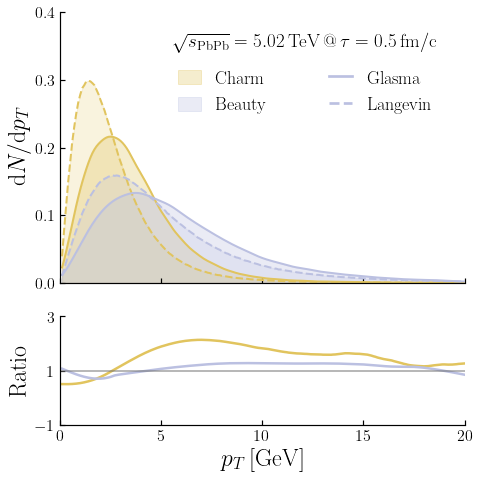

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from scipy import stats
from scipy.signal import savgol_filter

plt.style.use('nord_theme_light.mpltstyle')
plt.rcParams["figure.figsize"] = (7, 7)

fig, axes = plt.subplots(nrows=2, ncols=1, sharex=True, sharey=False, gridspec_kw={'height_ratios':[5,2]})
# fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0)

axes[1].set_xlabel(r'$p_T\,\mathrm{[GeV]}$')
axes[0].set_ylabel(r'$\mathrm{d}N/\mathrm{d}p_T$')
axes[1].set_ylabel(r'$\mathrm{Ratio}$')

results = pickle.load(open('results/hqs+glasma_charm+beauty.pickle', 'rb'))
data_lang = np.loadtxt('data/langevin_fonll_charm_beauty.dat', skiprows=1)
pTs_lang = data_lang[:, 0]

tags = ["fonll_charm", "fonll_beauty"]
# colors = ["#E2AB4A", "#E1C45E", "#BBC0E1"]
colors = ["#E1C45E", "#BBC0E1"]
labels = [r'$\mathrm{Charm}$', r'$\mathrm{Beauty}$']

i, ilang = 0, 2
for tag in tags:
    n, bins, _ = axes[0].hist(results['obs']['pts_tau_0.5'][tag], bins=50, density=True, alpha=0, color=colors[i])  

    density = stats.kde.gaussian_kde(results['obs']['pts_tau_0.5'][tag])
    axes[0].plot(pTs_lang, density(pTs_lang), color=colors[i], linewidth = 2, alpha=1.0)
    axes[0].fill_between(pTs_lang, density(pTs_lang), alpha=0.3, color=colors[i], label=labels[i])

    axes[0].plot(pTs_lang, data_lang[:, ilang], color=colors[i], linewidth=2, linestyle='--')
    axes[0].fill_between(pTs_lang, data_lang[:, ilang], alpha=0.2, color=colors[i])

    ratio = density(pTs_lang)/data_lang[:, i+2]
    # axes[1].plot(pTs_lang, ratio, color=colors[i], linewidth = 2.5, alpha=1.0)
    ratio_reduced_noise = savgol_filter(ratio, 51, 3, mode='nearest')
    axes[1].plot(pTs_lang, ratio_reduced_noise, color=colors[i], linewidth = 2.5, alpha=1.0)

    i += 1
    ilang += 2

axes[1].plot(pTs_lang, np.ones(len(pTs_lang)), color='#737373', linewidth = 2.0, alpha=0.5)

legend1 = axes[0].legend(loc = 'upper right', bbox_to_anchor=(0.55,0.85))
lines = axes[0].get_lines()
legend2 = axes[0].legend([lines[i] for i in [2, 3]], [r'$\mathrm{Glasma}$', r'$\mathrm{Langevin}$'], loc = 'upper right', ncol=1, bbox_to_anchor=(0.96,0.85))
axes[0].add_artist(legend1)

for line in legend2.get_lines():
    line.set_linewidth(2.7)

axes[0].set_xlim(0, 20)
axes[0].set_ylim(0, 0.4)
axes[0].xaxis.set_major_locator(MultipleLocator(5))
axes[0].yaxis.set_major_locator(MultipleLocator(0.1))
# axes[0].yaxis.get_major_ticks()[1].label1.set_visible(False)
axes[1].set_yticks([-1, 1, 3])
# axes[0].xaxis.set_ticks_position('none') 
axes[0].text(5.6, 0.35, r'$\sqrt{s_\mathrm{PbPb}}=5.02\,\mathrm{TeV}\,@\,\tau=0.5\,\mathrm{fm/c}$', size=19)

fig.tight_layout()
# plt.savefig('plots/dndpt_fonll_charm+beauty_glasma_vs_langevin.png', dpi=300, facecolor='white', transparent=False)

## Transverse momentum broadening $\Delta p_T^2$, charm and beauty, Glasma vs. Langevin

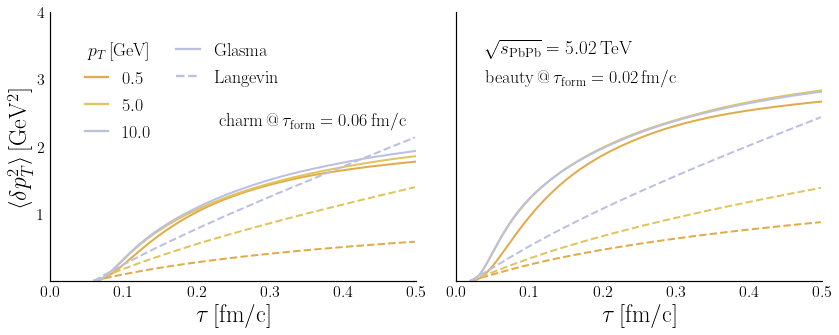

In [2]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

plt.style.use('nord_theme_light.mpltstyle')
plt.rcParams["figure.figsize"] = (12, 5)

fig, ax = plt.subplots(1, 2)

ax[0].set_ylabel(r'$\langle\delta p_T^2\rangle\,\mathrm{[GeV^2]}$')

for i in range(2):
    ax[i].set_xlabel(r'$\tau\,\mathrm{[fm/c]}$')

colors = ["#E2AB4A", "#E1C45E", "#BBC0E1"]
labels = [r'$0.5$', r'$5.0$', r'$10.0$']

results = pickle.load(open('results/hqs+glasma_charm+beauty.pickle', 'rb'))

quarks = ['charm', 'beauty']
ax_quark = 0
for quark in quarks:
    tags = ["toy_" + quark + '_pT_0.5', "toy_" + quark + '_pT_5.0', "toy_" + quark + '_pT_10.0']

    i = 0
    for tag in tags:
        mom_broad_T = (results['obs']['mom_broad'][tag][:, 0] + results['obs']['mom_broad'][tag][:, 1])/3
        ax[ax_quark].plot(results['obs']['tau'][quark], mom_broad_T, color=colors[i], linewidth=2)
        
        data_lang = np.loadtxt('data/langevin_' + quark + '_broadening.dat', skiprows=1)
        # ax[ax_quark].plot(data_lang[:, 0], data_lang[:, i+1], color=colors[i], linewidth=2, linestyle='--')
        # add origin values
        tau_lang, broad_lang = np.insert(data_lang[:, 0],0,results['obs']['tau'][quark][0]), np.insert(data_lang[:, i+1], 0,0)
        ax[ax_quark].plot(tau_lang, broad_lang, color=colors[i], linewidth=2, linestyle='--')
        i = i+1
    ax_quark +=1

lines = ax[0].get_lines()
legend1 = ax[0].legend([lines[i] for i in [0,2,4]], labels, loc = 'upper left', ncol=1, bbox_to_anchor=(0.05,0.95), title=r'$p_T\,\mathrm{[GeV]}$')
legend2 = ax[0].legend([lines[i] for i in [4,5]], [r'$\mathrm{Glasma}$', r'$\mathrm{Langevin}$'], loc = 'upper left', bbox_to_anchor=(0.3,0.95))
ax[0].add_artist(legend1)

for line in legend2.get_lines():
    line.set_linewidth(2.3)
for line in legend1.get_lines():
    line.set_linewidth(2.3)

for i in range(2):
    ax[i].set_xlim(0, 0.5)
    ax[i].set_ylim(0, 4.0)
    ax[i].xaxis.set_major_locator(MultipleLocator(0.1))
    ax[i].yaxis.get_major_ticks()[1].label1.set_visible(False)
    ax[i].yaxis.set_major_locator(MultipleLocator(1.0))
    ax[i].tick_params(axis=u'both', which=u'both',length=0)

ax[1].set_yticklabels([])
plt.subplots_adjust(wspace=0.05, hspace=0)

ax[1].text(0.04, 3.4, r'$\sqrt{s_\mathrm{PbPb}}=5.02\,\mathrm{TeV}$', size=19)
ax[0].text(0.23, 2.3, r'$\mathrm{charm}\,@\,\tau_\mathrm{form}=0.06\,\mathrm{fm/c}$', size=18)
ax[1].text(0.04, 2.95, r'$\mathrm{beauty}\,@\,\tau_\mathrm{form}=0.02\,\mathrm{fm/c}$', size=18)

plt.tight_layout()
# plt.savefig('plots/momentum_broadening_charm+beauty_glasma_vs_langevin_qm22.png', dpi=300, facecolor='white', transparent=False)

## Derivative of $\Delta p_T^2$ in double-log scale, charm and beauty, Glasma vs. Langevin

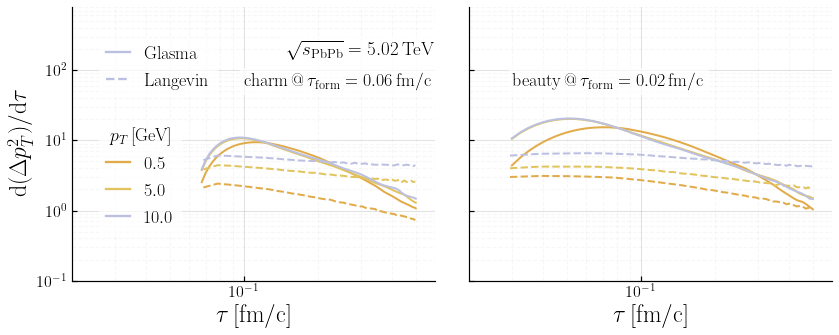

In [3]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from scipy import signal

plt.style.use('nord_theme_light.mpltstyle')
plt.rcParams["figure.figsize"] = (12, 5)

fig, ax = plt.subplots(1, 2)

ax[0].set_ylabel(r'$\mathrm{d}(\Delta p_T^2)/\mathrm{d}\tau$')

for i in range(2):
    ax[i].set_xlabel(r'$\tau\,\mathrm{[fm/c]}$')

colors = ["#E2AB4A", "#E1C45E", "#BBC0E1"]
labels = [r'$0.5$', r'$5.0$', r'$10.0$']

results = pickle.load(open('results/hqs+glasma_charm+beauty.pickle', 'rb'))

quarks = ['charm', 'beauty']
ax_quark = 0
for quark in quarks:
    tags = ["toy_" + quark + '_pT_0.5', "toy_" + quark + '_pT_5.0', "toy_" + quark + '_pT_10.0']

    i = 0
    for tag in tags:
        data_lang = np.loadtxt('data/langevin_' + quark + '_broadening.dat', skiprows=1)

        tau_glasma = results['obs']['tau'][quark]
        absolute_val_array = np.abs(tau_glasma - data_lang[0, 0])
        index = absolute_val_array.argmin()

        mom_broad_T = (results['obs']['mom_broad'][tag][:, 0] + results['obs']['mom_broad'][tag][:, 1])/3
        derivative = np.diff(mom_broad_T[index-1:len(tau_glasma)]) / np.diff(tau_glasma[index-1:len(tau_glasma)])
        ax[ax_quark].plot(tau_glasma[index:len(tau_glasma)], signal.savgol_filter(derivative, 51, 10), color=colors[i], linewidth=2)

        ax[ax_quark].plot(data_lang[:, 0], data_lang[:, i+4], color=colors[i], linewidth=2, linestyle='--')

        i = i+1
    ax_quark +=1

lines = ax[0].get_lines()
legend1 = ax[0].legend([lines[i] for i in [0,2,4]], labels, loc = 'upper left', ncol=1, bbox_to_anchor=(0.05,0.62), title=r'$p_T\,\mathrm{[GeV]}$')
legend2 = ax[0].legend([lines[i] for i in [4,5]], [r'$\mathrm{Glasma}$', r'$\mathrm{Langevin}$'], loc = 'upper left', bbox_to_anchor=(0.05,0.92))
ax[0].add_artist(legend1)

for line in legend2.get_lines():
    line.set_linewidth(2.3)
for line in legend1.get_lines():
    line.set_linewidth(2.3)

for i in range(2):
    ax[i].set_xlim(0.02, 0.6)
    ax[i].set_ylim(0.1, 800)
    ax[i].set_xscale('log')
    ax[i].set_yscale('log')
    ax[i].grid(True, which='both')
    ax[i].grid(b=True, which='minor', color='#737373', linestyle='--', alpha=0.05)

ax[1].set_yticklabels([])
plt.subplots_adjust(wspace=0.05, hspace=0)

t1 = ax[0].text(0.15, 170, r'$\sqrt{s_\mathrm{PbPb}}=5.02\,\mathrm{TeV}$', size=19)
t2 = ax[0].text(0.1, 60, r'$\mathrm{charm}\,@\,\tau_\mathrm{form}=0.06\,\mathrm{fm/c}$', size=18)
t3 = ax[1].text(0.03, 60, r'$\mathrm{beauty}\,@\,\tau_\mathrm{form}=0.02\,\mathrm{fm/c}$', size=18)
t1.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='white'))
t2.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='white'))
t3.set_bbox(dict(facecolor='white', alpha=0.7, edgecolor='white'))

plt.tight_layout()
# plt.savefig('plots/derivative_momentum_broadening_charm+beauty_glasma_vs_langevin.png', dpi=300, facecolor='white', transparent=False)

## Spectra for charm and beauty, Glasma vs. Langevin

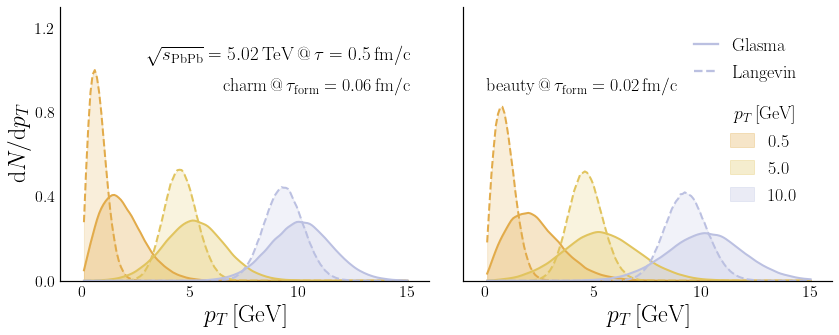

In [4]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from scipy import stats

plt.style.use('nord_theme_light.mpltstyle')
plt.rcParams["figure.figsize"] = (12, 5)

fig, ax = plt.subplots(1, 2)

ax[0].set_ylabel(r'$\mathrm{d}N/\mathrm{d}p_T$')

for i in range(2):
    ax[i].set_xlabel(r'$p_T\,\mathrm{[GeV]}$')

colors = ["#E2AB4A", "#E1C45E", "#BBC0E1"]
labels = [r'$0.5$', r'$5.0$', r'$10.0$']

results = pickle.load(open('results/hqs+glasma_charm+beauty.pickle', 'rb'))

quarks = ['charm', 'beauty']
ax_quark = 0
for quark in quarks:
    tags = ["toy_" + quark + '_pT_0.5', "toy_" + quark + '_pT_5.0', "toy_" + quark + '_pT_10.0']

    data_lang = np.loadtxt('data/langevin_' + quark + '_distrib.dat', skiprows=1)
    pTs_lang = data_lang[:, 0]

    i, ilang = 0, 1
    for tag in tags:
        n, bins, _ = ax[ax_quark].hist(results['obs']['pts_tau_0.3'][tag], bins=30, density=True, alpha=0, color=colors[i])  

        density = stats.kde.gaussian_kde(results['obs']['pts_tau_0.3'][tag])
        ax[ax_quark].plot(pTs_lang, density(pTs_lang), color=colors[i], linewidth = 2, alpha=1.0)
        ax[ax_quark].fill_between(pTs_lang, density(pTs_lang), alpha=0.3, color=colors[i], label=labels[i])

        ax[ax_quark].plot(pTs_lang, data_lang[:, ilang], color=colors[i], linewidth=2, linestyle='--')
        ax[ax_quark].fill_between(pTs_lang, data_lang[:, ilang], alpha=0.2, color=colors[i])

        i += 1
        ilang += 1

    ax_quark +=1

legend1 = ax[1].legend(loc = 'upper right', bbox_to_anchor=(0.95,0.7), title=r'$p_T\,\mathrm{[GeV]}$')
lines = ax[1].get_lines()
# legend1 = ax[0].legend([lines[i] for i in [0,2,4]], labels, loc = 'upper left', ncol=1, bbox_to_anchor=(0.05,0.95), title=r'$p_T\,\mathrm{[GeV]}$')
legend2 = ax[1].legend([lines[i] for i in [4,5]], [r'$\mathrm{Glasma}$', r'$\mathrm{Langevin}$'], loc = 'upper right', bbox_to_anchor=(0.95,0.95))
ax[1].add_artist(legend1)

for line in legend2.get_lines():
    line.set_linewidth(2.3)
for line in legend1.get_lines():
    line.set_linewidth(2.3)

for i in range(2):
    ax[i].set_xlim(-1, 16)
    ax[i].set_ylim(0, 1.3)
    ax[i].xaxis.set_major_locator(MultipleLocator(5))
    # ax[i].yaxis.get_major_ticks()[1].label1.set_visible(False)
    ax[i].yaxis.set_major_locator(MultipleLocator(0.4))
    ax[i].tick_params(axis=u'both', which=u'both',length=0)

ax[1].set_yticklabels([])
plt.subplots_adjust(wspace=0.05, hspace=0)

ax[0].text(3, 1.05, r'$\sqrt{s_\mathrm{PbPb}}=5.02\,\mathrm{TeV}\,@\,\tau=0.5\,\mathrm{fm/c}$', size=19)
ax[0].text(6.5, 0.9, r'$\mathrm{charm}\,@\,\tau_\mathrm{form}=0.06\,\mathrm{fm/c}$', size=18)
ax[1].text(0.05, 0.9, r'$\mathrm{beauty}\,@\,\tau_\mathrm{form}=0.02\,\mathrm{fm/c}$', size=18)

plt.tight_layout()
# plt.savefig('plots/pT_spectrum_charm_vs_beauty_glasma_vs_langevin_qm22.png', dpi=300, facecolor='white', transparent=False)